In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1747862570614, experiment_id='1', last_update_time=1747862570614, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

### Download datasource

In [3]:
def dataset_creation():
    color = input('Color')
    year = input('Year')
    month = input('Month')
    url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/'+color+'_tripdata_'+year+'-'+month+'.parquet'
    df = pd.read_parquet(url)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df['duration'] = None
    df['duration']= df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df['duration'].dt.total_seconds()/60
    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    return df

In [4]:
training_dataset = dataset_creation()

In [5]:
evaluation_dataset = dataset_creation()

### Data Cleaning (if necessary)

In [6]:
def remove_outliers_iqr(df, column, lower_quantile=0.25, upper_quantile=0.75, factor=1.5):
    Q1 = df[column].quantile(lower_quantile)
    Q3 = df[column].quantile(upper_quantile)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

In [7]:
training_dataset_cleaned = remove_outliers_iqr(training_dataset, 'duration')

In [8]:
evaluation_dataset_cleaned = remove_outliers_iqr(evaluation_dataset, 'duration')

### Train Model

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#### Pre-set Training dataset

In [10]:
#Feature selection

categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
target = 'duration'

In [11]:
# Vectorizing categorical data
dv = DictVectorizer()
train_dict = training_dataset_cleaned[categorical + numerical].to_dict(orient='records')    

X_train = dv.fit_transform(train_dict)
y_train = training_dataset_cleaned[target].values

In [12]:
# Vectorizing Test Dataset

test_dict = evaluation_dataset_cleaned[categorical + numerical].to_dict(orient='records')    

X_test = dv.transform(test_dict)
y_test = evaluation_dataset_cleaned[target].values

In [13]:
# Choosing Model

model = LinearRegression()

In [14]:
# Training Model

model.fit(X_train, y_train)

LinearRegression()

In [15]:
# Making Prediction

y_pred = model.predict(X_test)

In [34]:
with mlflow.start_run():
    mlflow.log_param("model", "LinearRegression")
    mlflow.log_param("alpha", 0.01)
    mlflow.log_param("l1_ratio", 0.5)
    mlflow.log_metric("rmse", root_mean_squared_error(y_test, y_pred))
    mlflow.log_param("train_data_path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("test_data_path","./data/green_tripdata_2021-02.parquet")
    mlflow.log_param("categorical_features", categorical)
    mlflow.log_param("numerical_features", numerical)
    mlflow.log_param("target", target)      

    alpha = 0.01
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    root_mean_squared_error(y_test, y_pred)

#### Model evaluation

In [21]:
from sklearn.metrics import root_mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
def model_evaluator(y_train, y_pred):
    # 4. Evaluate the model
    mse = root_mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")

    sns.distplot(y_pred, label='prediction')
    sns.distplot(y_train, label='actual')
    
    plt.legend()

Mean Squared Error: 9.46
R² Score: 0.25


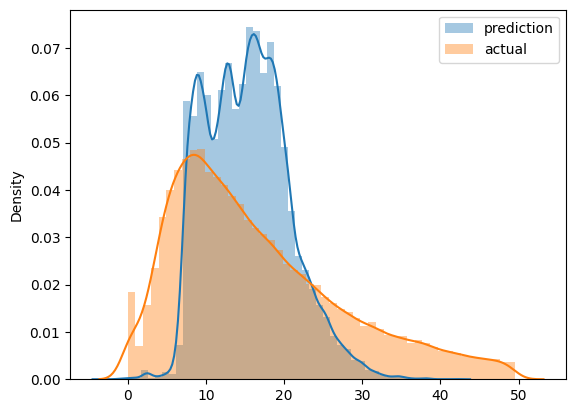

In [23]:
model_evaluator(y_test, y_pred)